### Shockley–Queisser limit for Dye-sensitized Solar Cells
- @author: Subrata Sarker
- Date: 2020.04.06

In [322]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from ipywidgets import interactive

In [323]:
%matplotlib inline
plt.ion()
plt.style.use('ggplot')

In [324]:
# constants
k = 1.38064852e-23  # m^2 kg s^-2 K^-1, Boltzmi constant
h = 6.62607004e-34   # m^2 kg s^-1    , planck constant
c = 2.99792458e8     # m s^-1         , speed of light
eV = 1.6021766208e-19  # joule        , eV to joule
q = 1.6021766208e-19  # C             , elemental charge

In [325]:
class SQlim:
    def __init__(self, solirr="ASTMG173.csv", T=300, EQE_EL=1.0, intensity=1.0):
        """
        solirr: AM1.5 solar irradiance (http://rredc.nrel.gov/solar/spectra/am1.5/)
        T: temperature in K
        EQE_EL: radiative efficiency (EL quantum yield)
        intensity: light concentration, 1.0 = one Sun, 100 mW/cm^2
        """
        try:
            T, EQE_EL, intensity = float(T), float(EQE_EL), float(intensity)
        except:
            raise ValueError("Invalid input for solirr, T, EQE_EL, or intensity")

        if T <= 0 or EQE_EL > 1.0 or EQE_EL <= 0:
            raise ValueError("Both T and EQE_EL must be greater than 0 and " +
                             "EQE_EL cannot be greater than 1.0")
        self.T = T
        self.EQE_EL = EQE_EL
        self.intensity = intensity
        
        if os.path.isfile(solirr):
            ref_solar = np.loadtxt(solirr, delimiter=",", skiprows=2)
            self.WL = ref_solar[:, 0]
            self.solar_per_nm =  ref_solar[:, 2]
        else:
            raise ValueError("The reference solar spectra was not found!")

        E = 1240.0 / self.WL  # eV

        # jacobian transformation, W m^-2 eV^-1
        solar_per_E = self.solar_per_nm * (eV / 1e-9) * h * c / (eV * E)**2

        # linear interpolation to get an equally spaced spectrum
        Es = np.arange(0.32, 4.401, 0.002)
        AM15 = np.interp(Es, E[::-1], solar_per_E[::-1])
        self.AM15flux = AM15 / (Es * eV)  # number of photon m^-2 eV^-1 s^-1
        self.Es = Es
        
        self.calculate()    
        
    
    def __repr__(self):
        s = "<SQlim:"
        conditions = []
        if self.T != 300.0:
            conditions.append("T={:.0f}K".format(self.T))
        if self.intensity != 1.0:
            conditions.append("{:.4g}-Sun".format(self.intensity))
        if self.EQE_EL != 1.0:
            conditions.append("EQE_EL={:.2E}".format(self.EQE_EL))

        if conditions:
            return s + " [" + ", ".join(conditions) + "]" + ">"
        return s + " [standard]>"

    def calculate(self):
        self.J0 = self.__cal_E_J0()  # dark saturation current density
        self.Jsc = self.__cal_E_Jsc()  # shor-circuit current density
        self.Voc = self.__cal_E_Voc()  # open circuit voltage
        self.PCE = self.__cal_E_PCE()  # power conversion efficiency
        # flll factor (%)
        self.FF = self.PCE / (self.Voc*self.Jsc) * 100.0 * self.intensity
        self.paras = {"Voc": self.Voc, "Jsc": self.Jsc, "J0": self.J0,
                      "FF": self.FF, "PCE": self.PCE}
        return None

    def __cal_E_Jsc(self):
        fluxcumm = cumtrapz(self.AM15flux[::-1], self.Es[::-1], initial=0)
        fluxaboveE = fluxcumm[::-1] * -1 * self.intensity
        Jsc = fluxaboveE * q * 0.1  # mA/cm^2  (0.1: from A/m2 to mA/cm2)
        return Jsc

    def __cal_E_J0(self):
        '''
        Calculate and return E vs J0, the dark saturation current
        J0 = q * (integrate(phi dE) from E to infinity)  / EQE_EL
        phi is the black body radiation at T (flux vs energy)

        '''
        phi = 2 * np.pi * (((self.Es*eV)**2) * eV / ((h**3) * (c**2)) / (
                           np.exp(self.Es*eV / (k*self.T)) - 1))

        # fluxcumm = sp.integrate.cumtrapz(phi[::-1], self.Es[::-1], initial=0)
        fluxcumm = cumtrapz(phi[::-1], self.Es[::-1], initial=0)
        fluxaboveE = fluxcumm[::-1] * -1
        J0 = fluxaboveE * q * 0.1 / self.EQE_EL  # (0.1: from A/m2 to mA/cm2)
        J0[-1] = np.nan  # avoid divide by zero when calculating Voc
        return J0

    def __cal_E_Voc(self):
        '''
        Calculate and return E vs Voc
        Voc = (kT/q)*[ ln(Jsc/J0 + 1 )]
        '''
        return (k*self.T/q) * np.log((self.Jsc/self.J0) + 1)

    def __cal_E_PCE(self):
        PCE = np.zeros(self.Es.size)
        for i, E in enumerate(self.Es):
            V = np.arange(0, E, 0.001)  # can change upperbound to Voc
            J = -1 * self.Jsc[i] + self.J0[i] * (
                np.exp(q*V / (k*self.T)) - 1)
            PCE[i] = -1 * np.min(J*V) / self.intensity
        PCE[-1] = 0 # so that np.argmax returns the index of maximum value correctly
        return PCE

    def simulate_JV(self, Eg, plot_dark=False, plot=True, paras=False, Vstep=0.001, Vmin=-0.5):
        """
        Simulate J-V curves for a solar cell at given Eg
        """

        if not self.Es[0] <= Eg <= self.Es[-1]:
            print("invalid bandgap \nvalid range: 0.32 to 4.4")
            return
        V = np.arange(Vmin, Eg, Vstep)
        paras = self.get_paras(Eg, toPrint=False)
        J0, Jsc = paras["J0"], paras["Jsc"]

        J = -1.0 * Jsc + J0 * (np.exp(q*V / (k*self.T)) - 1)
        if plot_dark:
            Jdark = J + Jsc
        mask = (J <= 200)
        if plot:
            # to do:
            # could modify the method to take xlim, ylim as inputs
            # move 'title' into the figure and add add Voc Jsc FF, PCE to it
            title = "Theoretical J-V for Eg = {:.2f} eV".format(Eg)
            # plt.figure()
            plt.plot(V[mask], J[mask], 'r')
            plt.plot([-1, Eg], [0, 0], 'k')
            plt.plot([0, 0], [-2 * Jsc, 200], 'k')
            if plot_dark:
                plt.plot(V[mask], Jdark[mask], 'b')
            plt.ylim(-1.5 * Jsc, min(40, 1.5 * Jsc))
            plt.xlim(Vmin, Eg)
            plt.xlabel("Voltage (V)", fontsize=16)
            plt.ylabel("Current density (mA/$\mathregular{cm^2}$)",
                       fontsize=16)
            plt.tick_params(labelsize=16)
            plt.title(title)
            plt.tight_layout()
        
        if paras:
            self.get_paras(Eg)

        return np.vstack([V, J])  # col1: V, col2:J, photocurrent only

    def get_paras(self, Eg, toPrint=True):
        '''
        input Eg, return or print the corresponding parameters
        if toPrint == True : print the result, return nothing
        if toPrint == False: return the result as a dictionary
        '''

        if not self.Es[0] <= Eg <= self.Es[-1]:
            print("invalid bandgap \nvalid range: 0.32 to 4.4")
            return
        para = {}
        # could change these to binary search
        para["Voc"] = np.interp([Eg], self.Es, self.Voc)[0]
        para["Jsc"] = np.interp([Eg], self.Es, self.Jsc)[0]
        para["FF"] = np.interp([Eg], self.Es, self.FF)[0]
        para["PCE"] = np.interp([Eg], self.Es, self.PCE)[0]
        para["J0"] = np.interp([Eg], self.Es, self.J0)[0]

        if toPrint:  # won't return anything; print in console instead
            text = "<Bandgap: {0:.2f} eV>\n".format(Eg)
            text += "J0 = {0:.3g} \t\t mA/cm^2\n".format(para["J0"])
            text +="Voc = {0:.4g} \t\t V\n".format(para["Voc"])
            text +="Jsc = {0:.4g} \t\t mA/cm^2\n".format(para["Jsc"])
            text += "FF  = {0:.2f} \t\t %\n".format(para["FF"])
            text += "PCE = {0:.3f} \t\t %\n".format(para["PCE"])
            print(text)
            return

        return para

    def saveall(self, savename="SQ limit"):
        """
        save the data as a .csv file
        """
        pass

    def plot(self, para="PCE", xlims=(0.32, 4.5)):
        """
        plot one parameters in a plot
        paras: "Voc", "Jsc", "FF", "PCE", or "J0"
        J0 will be plotted in a semi-log plot.
        """

        if para not in self.paras:
            print("Invalid input! Valid inputs are:")
            print('"Voc", "Jsc", "FF", "PCE", and "J0"')
            return
        yunits = {"Voc": "(V)", "Jsc": "(mA/$\mathregular{cm^2}$)",
                  "FF": "(%)", "J0": "(mA/$\mathregular{cm^2}$)",
                  "PCE": "(%)"}
        
        max_idx = np.argmax(self.PCE, axis=0)
        
        plt.figure(para)
        ax = plt.gca()
        ax.plot(self.Es, self.paras[para], lw=3)
        ax.plot(
            self.Es[max_idx], self.PCE[max_idx], "bo", 
            markersize=10, markeredgewidth=2, fillstyle='none'
        )

        if para == "J0":
            ax.set_yscale('log')
        ax.set_ylabel(para + " " + yunits[para], size=20)
        ax.set_xlim(xlims)
        ax.set_xlabel("Bandgap (eV)", size=20)
        ax.tick_params(labelsize=18)
        plt.tight_layout()
        plt.show()

        return

    def plotall(self, Eg, xlims=(0.32, 3.0)):
        """
        plot Voc, Jsc, FF, and PCE in a figure with 4 subplots
        """

        fig, ax = plt.subplots(2, 2, sharex=True)  # figsize=(8, 8)
        axs = [(0, 0), (0, 1), (1, 0), (1, 1)]
        ys = [self.Voc, self.Jsc, self.FF, self.PCE]
        ylabel = ["Voc (V)", "Jsc (mA/$\mathregular{cm^2}$)", "FF (%)",
                  "PCE (%)"]
        
        max_idx = np.argmax(self.PCE, axis=0)
        
        for i, a in enumerate(axs):
            ax[axs[i]].plot(self.Es, ys[i], lw=2)
            ax[axs[i]].plot(
                self.Es[max_idx], ys[i][max_idx], "bo", 
                markersize=7, markeredgewidth=2, fillstyle='none'
            )
            ax[axs[i]].set_ylabel(ylabel[i])
            plt.setp(ax[axs[i]].get_xticklabels(), visible=True)
            ax[axs[i]].set_xlabel("Bandgap (eV)")
            ax[axs[i]].tick_params(labelsize=12)
        ax[(0, 0)].set_xlim(xlims)
        plt.tight_layout()
        plt.show()
        return

    # some classmethods for calculating and ploting various conditions
    @classmethod
    def vary_temp(cls, T=(150, 200, 250, 300, 350),
                  xlim=(0.3, 4.0), attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print("Invalid attribute")
            return
        SQs = [SQlim(T=temp) for temp in sorted(T)]
        for SQ in SQs:
            plt.plot(Es, getattr(SQ, attr), label="T = {} K".format(SQ.T))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def vary_EQE_EL(cls, EQE_EL=(1E-6, 1E-4, 1E-2, 1),
                    xlim=[0.3, 4.0], attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print("Invalid attribute")
            return
        SQs = [SQlim(EQE_EL=EQE) for EQE in sorted(EQE_EL, reverse=True)]
        for SQ in SQs:
            strEQE = "{:0.2E}".format(SQ.EQE_EL)
            num, expo = strEQE[:4], str(int(strEQE[5:]))
            plt.plot(Es, getattr(SQ, attr),
                     label=r"$EQE_{EL} = %s \times 10^{%s}$" % (num, expo))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def vary_suns(cls, Suns=(1, 10, 100, 1000), xlim=[0.3, 4.0], attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print("Invalid attribute")
            return
        SQs = [SQlim(intensity=sun) for sun in sorted(Suns, reverse=True)]
        for SQ in SQs:
            plt.plot(self.Es, getattr(SQ, attr),
                     label="{:4G} sun".format(SQ.intensity))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def __helper_plt(cls, xlim, attr="PCE"):
        ylabel = {"PCE": "Efficiency (%)", "Voc": "Voc (V)", "FF": "FF (%)",
                  "Jsc": "Jsc (mA/$\mathregular{cm^2}$)",
                  "J0": "J0 (mA/$\mathregular{cm^2}$)"}
        plt.xlabel("Bandgap (eV)", size=20)
        plt.ylabel(ylabel[attr], size=20)
        plt.xlim(xlim)
        plt.tick_params(labelsize=18)
        ax = plt.gca()
        ax.legend(loc='upper right', fontsize=16).draggable()
        plt.tight_layout()

        return

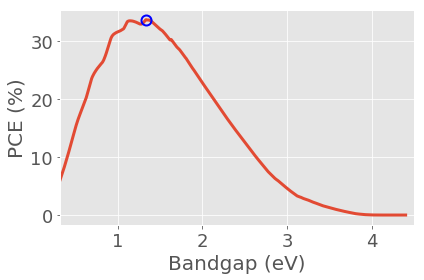

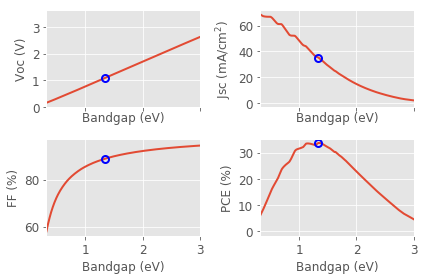

In [326]:
SQ = SQlim()
SQ.plot()
SQ.plotall(Eg=1.34)
plt.show()

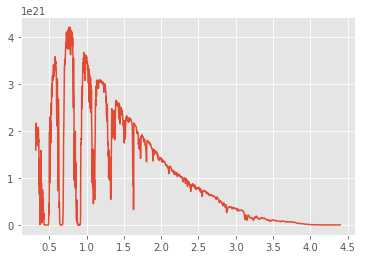

In [327]:
plt.plot(SQ.Es, SQ.AM15flux)
plt.show()

In [329]:
interactive_plot = interactive(
    SQ.simulate_JV,Eg=(0.4, 4, 0.01), plot_dark=True, 
    plot=True, paras=True,
    Vstep=(0.001, 0.1, 0.001), 
    Vmin=(-0.5, 0))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(FloatSlider(value=2.2, description='Eg', max=4.0, min=0.4, step=0.01), Checkbox(value=Tr…